In [1]:
# pyyaml (yaml) :: parses configuration files (YAML files)
# see https://www.cloudbees.com/blog/yaml-tutorial-everything-you-need-get-started for more information on YAML files
import yaml 

# huggingface :: datasets : dataset-handling libraries from huggingface
from datasets import load_dataset
#from datasets.filesystems import S3FileSystem # for S3 interactions

# huggingface :: transformers : transformer, trainer and tokenizer objects for the actual training
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# transformer_imports.py :: contains all our transformer imports and the MODEL DICT
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

# pytorch (torch) :: machine learning and deep learning method library
import torch

# deepspeed :: accelerator and memory management library
import deepspeed

# gradient checkpointing to fit larger models (when not even 1 batch fits)
from torch.utils.checkpoint import checkpoint

# nvidia management library, interface with gpu like nvidia-smi
from pynvml import *

/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import time
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import random
from tqdm import tqdm
import shutil
import nvidia_smi
import wandb
os.environ["WANDB_DISABLED"] = "false"
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

In [3]:
nvidia_smi.nvmlInit()

In [4]:
# nltk punkt sentence tokenizer, divides text into a list of sentences
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
!nvidia-smi

Wed Apr  5 16:22:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   31C    P8    16W / 300W |      0MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [7]:
def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [8]:
path_to_config = "../configs/gpt2-refl-04-apr-2023.yaml"

In [9]:
# open yaml config as a strema and load into config_dict
with open(path_to_config, "r") as stream:
    try:
        config_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print("Configuration load failed!")
        print(exc)

In [10]:
df = pd.read_csv(config_dict["data_train_path"])
df_val = pd.read_csv(config_dict["data_validation_path"])

In [11]:
df.dropna(inplace=True)  # drop NA values
triplets = df.triplet.copy()  # copy over triplets

In [12]:
val_triplets = df_val.triplet.copy()  # validation triplets

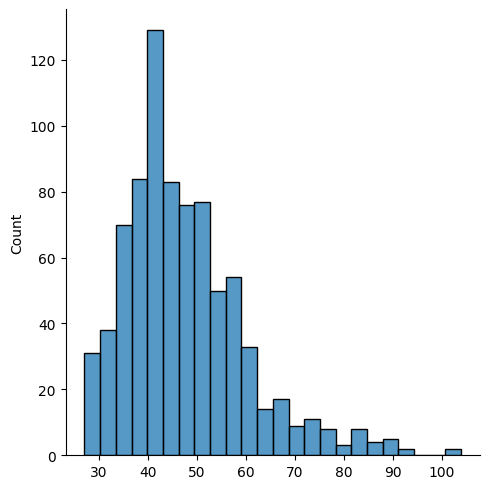

In [13]:
# how long is our training data?
doc_lengths = []
for triplet in triplets:
    tokens = nltk.word_tokenize(triplet)
    doc_lengths.append(len(tokens))
doc_lengths = np.asarray(doc_lengths)
sns.displot(doc_lengths)

In [14]:
np.average(doc_lengths)
# on average, we have ~47.5 tokens per entry, a good thing for GPT2 embedding size of 768 in gpt-small

47.53465346534654

In [15]:
model_name = config_dict['model_name']
hyperparameters = config_dict['training_settings']['hyperparameters']

In [16]:
model_name

'gpt2-large'

In [17]:
# load gpt-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

In [18]:
tokenizer.pad_token = tokenizer.eos_token

In [19]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|endoftext|> token has the id 50256
The end of sequence token <|endoftext|> has the id 50256
The padding token <|endoftext|> has the id 50256


In [20]:
raw_datasets = load_dataset('csv', data_files=config_dict['data_train_path'])
raw_datasets["validation"] = (load_dataset('csv', data_files=config_dict['data_validation_path']))["train"]
print(raw_datasets)

Using custom data configuration default-918e763cff422540
Found cached dataset csv (/home/ubuntu/.cache/huggingface/datasets/csv/default-918e763cff422540/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 704.81it/s]
Using custom data configuration default-851a0b80f47d644b
Found cached dataset csv (/home/ubuntu/.cache/huggingface/datasets/csv/default-851a0b80f47d644b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 712.95it/s]

DatasetDict({
    train: Dataset({
        features: ['triplet'],
        num_rows: 808
    })
    validation: Dataset({
        features: ['triplet'],
        num_rows: 95
    })
})


In [21]:
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets['train'][0][key][:256]}")

TRIPLET: Prompt: Now, what is the thing you like least about smoking?
Response: The medical risks
Reflection: You are aware of the medical risks of smoking and you worry about what might happen if you do not quit.



In [22]:
#helper for tokenizing everything
def tokenize_function(examples):
    return tokenizer(examples["triplet"], truncation=True)

In [23]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/csv/default-918e763cff422540/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-45d0eb2b097ab07b.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/csv/default-851a0b80f47d644b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-20d5b4a74cb50ca6.arrow


In [24]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['triplet', 'input_ids', 'attention_mask'],
        num_rows: 808
    })
    validation: Dataset({
        features: ['triplet', 'input_ids', 'attention_mask'],
        num_rows: 95
    })
})

In [25]:
tokenized_datasets = tokenized_datasets.remove_columns(["triplet"])

In [26]:
# amount of examples passed through model before a backwards pass
batch_size = hyperparameters['batch_size']

In [27]:
# config to instantiate model
configuration = GPT2Config.from_pretrained(model_name, output_hidden_states=False)


In [28]:
# instantiate model
model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)


In [29]:
# resize token embeddings for our custom tokens (e.g. bos_token)
model.resize_token_embeddings(len(tokenizer))

Embedding(50257, 1280)

In [30]:
device = torch.device("cuda")

In [31]:
# sends model to current device - in this case CUDA
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout)

In [32]:
# Set the seed value
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [33]:
# all the below set the corresponding values from the configuration file config.yaml:
model_name = config_dict["model_name"]
pretrained = config_dict["pretrained"]
data_train_path = config_dict["data_train_path"]
data_validation_path = config_dict["data_validation_path"]


output_data_dir = config_dict["output_data_dir"] + "/"
output_model_dir = config_dict["output_model_dir"] + "/"

hyperparameters = config_dict["training_settings"]["hyperparameters"]
hyperparameters["learning_rate"] = float(hyperparameters["learning_rate"])
hyperparameters["weight_decay"] = float(hyperparameters["weight_decay"])

deepspeed_config = config_dict["training_settings"]["deepspeed_settings"]

In [34]:
hyperparameters

{'find_hyperparams_automatically': False,
 'num_trials': 10,
 'fp16': True,
 'deepspeed': True,
 'grad_accumulation_steps': 2,
 'eval_batch_size': 1,
 'learning_rate': 0.0003,
 'epochs': 10,
 'warmup_steps': 100,
 'epsilon': '1e-7',
 'batch_size': 1,
 'sample_every': 100,
 'seed': 42,
 'eval_steps': 10,
 'weight_decay': 0.01}

In [35]:
learning_rate = hyperparameters['learning_rate']
epsilon = float(hyperparameters['epsilon'])  # epsilon must be a float, not str
epochs = hyperparameters['epochs']
warmup_steps = float(hyperparameters['warmup_steps'])
sample_every = float(hyperparameters['sample_every'])

In [36]:
model_name

'gpt2-large'

In [37]:
# os environment variables from HF for running deepspeed
# deepspeed requires a distributed environment even when only one process is used
# these environment variables emulate a launcher in the notebook
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [39]:
!ds_report

--------------------------------------------------
DeepSpeed C++/CUDA extension op report
--------------------------------------------------
NOTE: Ops not installed will be just-in-time (JIT) compiled at
      runtime if needed. Op compatibility means that your system
      meet the required dependencies to JIT install the op.
--------------------------------------------------
JIT compiled ops requires ninja
ninja .................. [OKAY]
--------------------------------------------------
op name ................ installed .. compatible
--------------------------------------------------
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
async_io ............... [NO] ....... [NO]
cpu_adagrad ............ [NO] ....... [OKAY]
cpu_a

## Deepspeed ZeRO

ZeRO leverages aggregate computation and memory resources of data parallelism to reduce the memory and compute requirements of each GPU

We partition various model training states (e.g. weights, gradients, and optimizer states) across available devices (GPUs and CPUs)

Zero Redundancy Optimizer can be used at 3 levels (stages) of optimization. We configure deepspeed with a zero_optimization configuration file.

In the file we specify which ZeRO stages we want enabled and how to configure them

DeepSpeed doesn't validate parameter names so we must watch for misspelled parameters. We can use the DeepSpeed engine start up log to see what values its going to use 

Some configuration values are required by both the trainer and deepspeed (e.g. batch size) so we have to be careful about conflicting definitions

Stage 2 and 3 are the most used versions of DeepSpeed, they provide the greatest ability to increase speed and reduce memory usage

### ZeRO Stage 1 - Optimizer State Partitioning
The optimizer states (e.g. Adam 32-bit weights, first, and second moment estimates) are partitioned across processes, so that each process only updates its own partition optimizer values

### ZeRO Stage 2 - Gradient Partitioning
The reduced 32-bit gradients for updating model weights are partitioned such that each process retains only the gradients corresponding to its portion of the optimizer states

### ZeRO Stage 3 - Parameter Partitioning
The 16-bit model parameters are partitioned across the processes. ZeRO-3 automatically collects and partitions them during forward and backward passes

ZeRO-3 also includes infinity offload engine to offload memory or computation to the CPU and NVMe memory for huge savings

Likely slower than ZeRO-2 if everything else is configured the same because the former has to gather model weights in addition to what ZeRO-2 does.
If ZeRO-2 meets our needs we might be okay sticking to it.

ZeRO-3 enables much higher scaling capacity at the cost of speed

In [38]:
# For gradient checkpointing, use HF training
# I tried custom gradient checkpointing, but am getting issues with HF ecosystem + pytorch checkpointing
# HF repository https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
# shows gradient checkpointing method, later i'll try pytorch lightning



training_args = TrainingArguments(output_dir=config_dict['output_model_dir'],
                                overwrite_output_dir=True,
                                fp16 = config_dict['training_settings']['hyperparameters']["fp16"],
                                deepspeed="../configs/ds_config_zero3.json",
                                evaluation_strategy = "steps", # used to be epoch
                                prediction_loss_only = True, #get rid of this if we end up adding metrics
                                logging_dir=f"./logs/",
                                logging_strategy="steps",
                                logging_steps=5,
                                save_strategy="no",
                                per_device_eval_batch_size=config_dict['training_settings']['hyperparameters']["eval_batch_size"],
                                gradient_accumulation_steps=config_dict['training_settings']['hyperparameters']["grad_accumulation_steps"],
                                learning_rate=config_dict['training_settings']['hyperparameters']["learning_rate"],
                                weight_decay=config_dict['training_settings']['hyperparameters']["weight_decay"],
                                num_train_epochs=config_dict['training_settings']['hyperparameters']["epochs"],
                                seed=config_dict['training_settings']['hyperparameters']["seed"],
                                per_device_train_batch_size=config_dict['training_settings']['hyperparameters']["batch_size"],
                                eval_steps=config_dict['training_settings']['hyperparameters']["eval_steps"]
                                )

[2023-04-05 16:23:18,071] [INFO] [comm.py:654:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


In [40]:
!nvidia-smi

Wed Apr  5 16:23:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   33C    P0    58W / 300W |   3897MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [41]:
# constructs the Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
    tokenizer=tokenizer
)

Using cuda_amp half precision backend


In [42]:
trainer.train() #training time

[2023-04-05 16:23:47,032] [INFO] [logging.py:93:log_dist] [Rank 0] DeepSpeed info: version=0.8.3, git-hash=unknown, git-branch=unknown
[2023-04-05 16:23:47,404] [INFO] [logging.py:93:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2023-04-05 16:23:48,955] [WARNING] [cpu_adam.py:86:__init__] FP16 params for CPUAdam may not work on AMD CPUs
Installed CUDA version 11.0 does not match the version torch was compiled with 11.7 but since the APIs are compatible, accepting this combination


Using /home/ubuntu/.cache/torch_extensions/py37_cu117 as PyTorch extensions root...
Creating extension directory /home/ubuntu/.cache/torch_extensions/py37_cu117/cpu_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ubuntu/.cache/torch_extensions/py37_cu117/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] /usr/local/cuda/bin/nvcc  -DTORCH_EXTENSION_NAME=cpu_adam -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -I/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/deepspeed/ops/csrc/includes -I/usr/local/cuda/include -isystem /home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/torch/include -isystem /home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/torch/include/torch/csrc/api/include -isystem /home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/torch/include/TH -isystem /home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/ubuntu/anaconda3/envs/torch_p37/include/python3.7m -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=co

RuntimeError: Error building extension 'cpu_adam'

In [ ]:
model.eval()
generation_config = config_dict['refgen']
config = config_dict

text = "Prompt: What do you want to change in your smoking?\nResponse: I don't want to change anything in my smoking.\n"
# encode the input text into tokens using the tokenizer
tokenized_text = tokenizer.encode(
    text, return_tensors="pt", padding=True, truncation=True
)
encodings_dict = tokenizer(text, truncation=True, max_length=256, padding="max_length")

input_ids = torch.tensor(encodings_dict['input_ids'])
input_ids = tokenized_text.to(device)

# sample model with generate() using no tokens, just let it generate
with torch.no_grad():
    sample_outputs = model.generate(input_ids,
                                    bos_token_id=tokenizer.bos_token_id,
                                    temperature = 0.8,
                                    # flag to use a sampling technique or greedy
                                    do_sample=generation_config['do_sample'],
                                    # penalize model for duplicating words
                                    repetition_penalty = 1.1,
                                    pad_token_id=tokenizer.pad_token_id,
                                    # of proposed words, only select from top k of them
                                    top_k=generation_config['top_k'],
                                    # max amount of tokens to generate
                                    max_length=256,
                                    # of propsed words, select from the words that add up to top_p value
                                    # e.g. top_p=0.26 x(0.15),y(0.1),z(0.05)
                                    # only select from x and y (0.15+0.1+0.05=0.3 which is too high)
                                    top_p=generation_config['top_p'],
                                    # num of independently computed returned sequences for each element in the batch.
                                    num_return_sequences=1
                                   )
    output = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)
    print(output)

In [47]:
# saving and loading the finetuned model
output_dir = '../models/gpt2-large-mi-reflector/'
tokenizer_dir = '../models/gpt2-large-mi-reflector/'

# create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# create output directory if needed
if not os.path.exists(tokenizer_dir):
    os.makedirs(tokenizer_dir)
    
    
print(f"Saving model to {output_dir}")

Saving model to ../models/gpt2-large-mi-reflector/


In [48]:
# Save trained model, configuration and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

Configuration saved in ../models/gpt2-large-mi-reflector/config.json
Configuration saved in ../models/gpt2-large-mi-reflector/generation_config.json
Model weights saved in ../models/gpt2-large-mi-reflector/pytorch_model.bin


In [49]:
tokenizer.save_pretrained(tokenizer_dir)

tokenizer config file saved in ../models/gpt2-large-mi-reflector/tokenizer_config.json
Special tokens file saved in ../models/gpt2-large-mi-reflector/special_tokens_map.json


('../models/gpt2-large-mi-reflector/tokenizer_config.json',
 '../models/gpt2-large-mi-reflector/special_tokens_map.json',
 '../models/gpt2-large-mi-reflector/vocab.json',
 '../models/gpt2-large-mi-reflector/merges.txt',
 '../models/gpt2-large-mi-reflector/added_tokens.json')

In [50]:
# save training arguments with trained model
torch.save(model.state_dict(), os.path.join(output_dir, 'training_args.bin'))